# Capstone Project: Biologics Yield

# Problem Statement and Objectives

- Clearly state the business and technical goal:
  - Predict biologics yield from upstream parameters (mixing time, temperature, pH, dissolved oxygen).
  - Identify which parameters and ranges are most associated with higher yield.

In [2]:
# Synthetic Data Generation
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid", context="talk")

In [3]:
# Random seed for reproducibility
np.random.seed(42)

# Number of batches
n_batches = 4000

# Generation of ealistic upstream parameters
mixing_time = np.random.uniform(30, 180, n_batches)     # minutes
temperature = np.random.uniform(34, 38, n_batches)      # °C
pH = np.random.uniform(6.6, 7.4, n_batches)             # pH units
dissolved_oxygen = np.random.uniform(20, 80, n_batches) # % saturation

# Optimal ranges
opt_temp = 36.5
opt_pH = 7.0
opt_DO_low, opt_DO_high = 40, 60

# Yield formula
yield_base = 50
yield_temp = -2 * (temperature - opt_temp)**2
yield_pH = -15 * (pH - opt_pH)**2
yield_DO = -0.03 * (np.maximum(0, dissolved_oxygen - opt_DO_high)**2 +
                    np.maximum(0, opt_DO_low - dissolved_oxygen)**2)
yield_mix = 0.02 * mixing_time  

# Combine components
noise = np.random.normal(0, 5, n_batches)
yield_final = yield_base + yield_temp + yield_pH + yield_DO + yield_mix + noise

# No negative yields
yield_final = np.clip(yield_final, 0, None)

# DataFrame creation
df = pd.DataFrame({
    "mixing_time": mixing_time,
    "temperature": temperature,
    "pH": pH,
    "dissolved_oxygen": dissolved_oxygen,
    "yield": yield_final
})

df.head()

,mixing_time,temperature,pH,dissolved_oxygen,yield
0,86.181018,36.287984,7.176214,59.258379,48.750555
1,172.607146,37.221729,7.149826,24.801954,45.001774
2,139.799091,37.040644,6.676603,34.539789,46.170629
3,119.798773,34.615600,7.338058,66.420761,42.120179
4,53.402796,34.596998,7.054778,51.721151,32.100559


In [4]:
import os

os.makedirs("data", exist_ok=True)
df.to_csv("data/synthetic_yield_data.csv", index=False)

df.head()

,mixing_time,temperature,pH,dissolved_oxygen,yield
0,86.181018,36.287984,7.176214,59.258379,48.750555
1,172.607146,37.221729,7.149826,24.801954,45.001774
2,139.799091,37.040644,6.676603,34.539789,46.170629
3,119.798773,34.615600,7.338058,66.420761,42.120179
4,53.402796,34.596998,7.054778,51.721151,32.100559


In [5]:
# Data Cleaing
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mixing_time       4000 non-null   float64
 1   temperature       4000 non-null   float64
 2   pH                4000 non-null   float64
 3   dissolved_oxygen  4000 non-null   float64
 4   yield             4000 non-null   float64
dtypes: float64(5)
memory usage: 156.4 KB


np.int64(0)

In [6]:
# Removing duplicates
df = df.drop_duplicates()

# Confirmation
df.duplicated().sum()

np.int64(0)

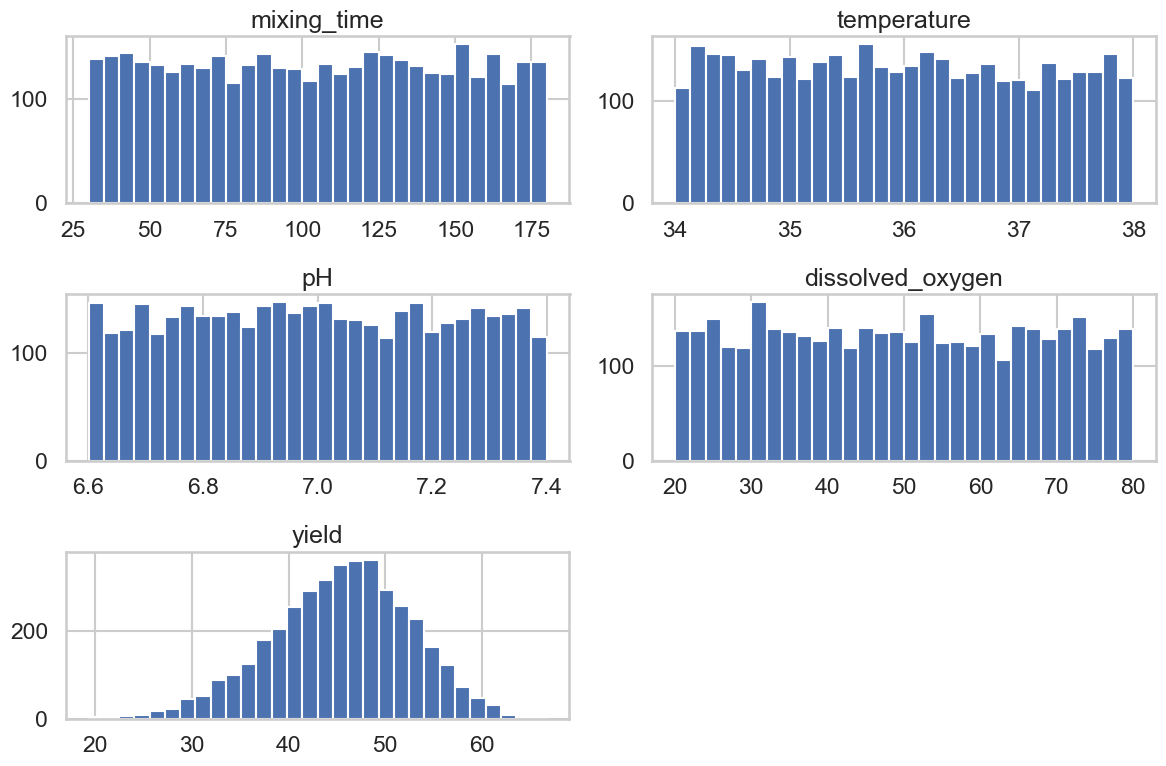

In [7]:
# Exploratory Data Analysis (EDA)
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

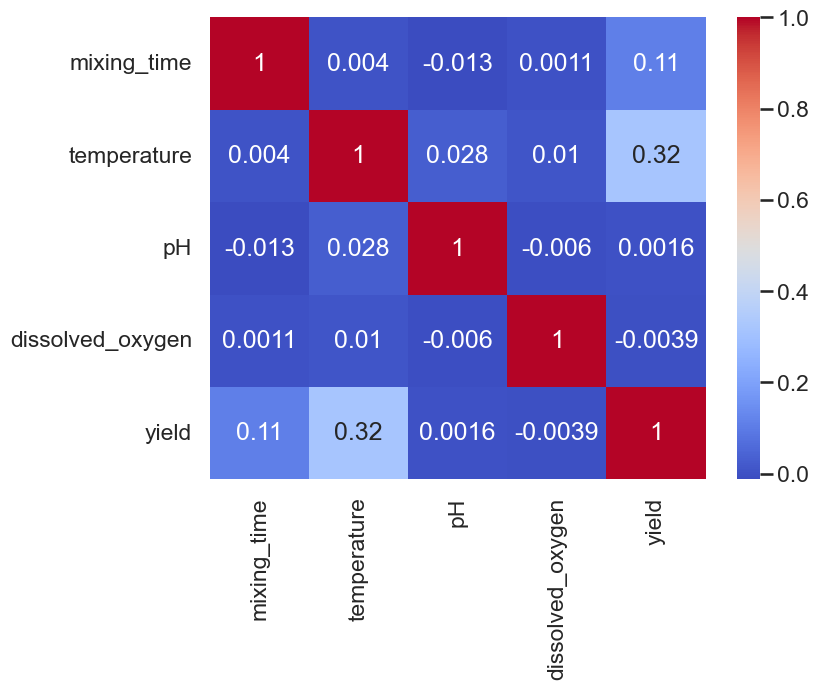

In [8]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

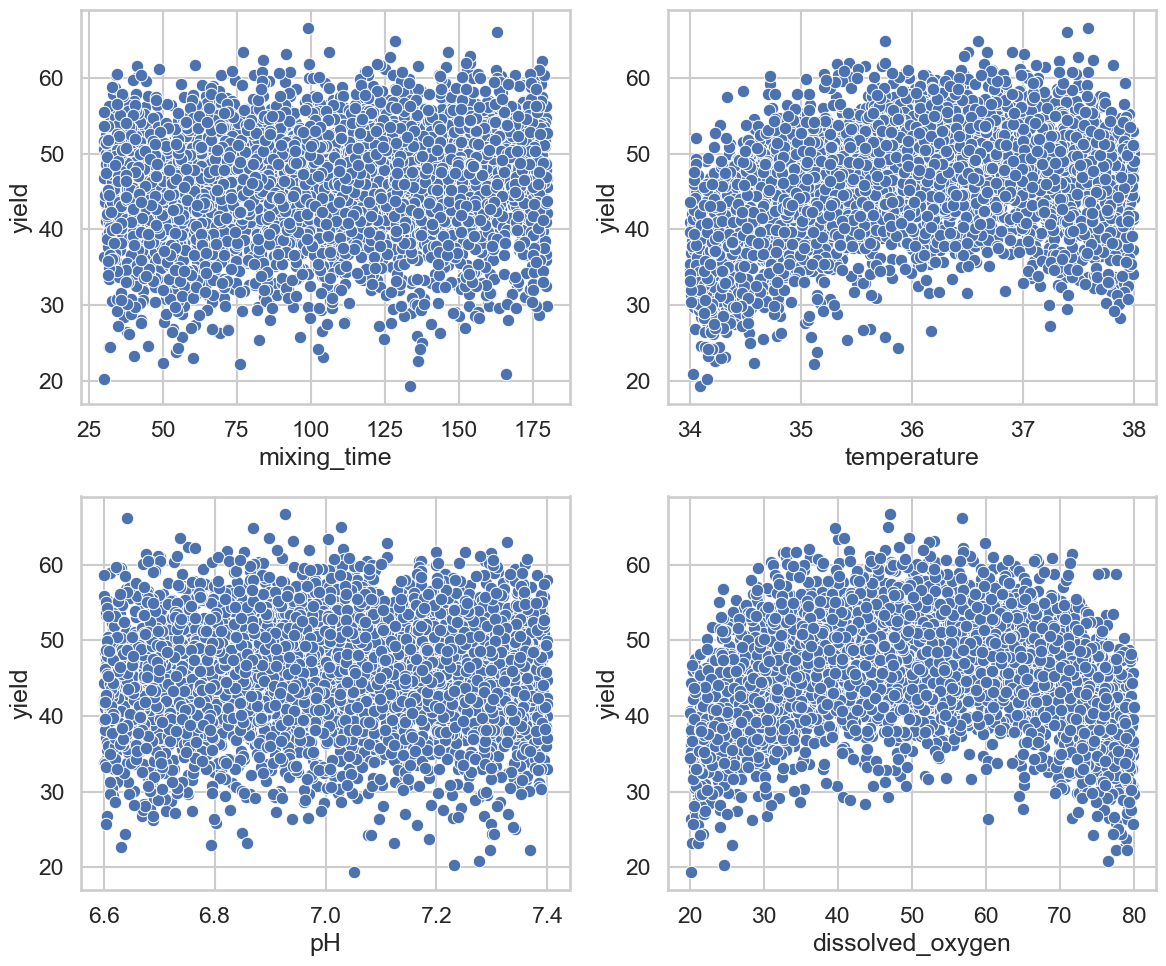

In [9]:
# Scatterplots vs yield
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(ax=axes[0,0], data=df, x="mixing_time", y="yield")
sns.scatterplot(ax=axes[0,1], data=df, x="temperature", y="yield")
sns.scatterplot(ax=axes[1,0], data=df, x="pH", y="yield")
sns.scatterplot(ax=axes[1,1], data=df, x="dissolved_oxygen", y="yield")

plt.tight_layout()
plt.show()

In [12]:
# Feature Engineering
# Note: This is a synthetic dataset, so all features are already numeric and do not require encoding

X = df[["mixing_time", "temperature", "pH", "dissolved_oxygen"]]
y = df["yield"]

X.head(), y.head()


(   mixing_time  temperature        pH  dissolved_oxygen
 0    86.181018    36.287984  7.176214         59.258379
 1   172.607146    37.221729  7.149826         24.801954
 2   139.799091    37.040644  6.676603         34.539789
 3   119.798773    34.615600  7.338058         66.420761
 4    53.402796    34.596998  7.054778         51.721151,
 0    48.750555
 1    45.001774
 2    46.170629
 3    42.120179
 4    32.100559
 Name: yield, dtype: float64)

In [13]:
# Baseline Regression Model
X = df[["mixing_time", "temperature", "pH", "dissolved_oxygen"]]
y = df["yield"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

rmse, r2

(6.845903899492135, 0.1340173803417376)

# Conclusions and Next Steps

Conclusions:
The synthetic dataset behaved like a realistic upstream bioprocess, showing clear nonlinear links between temperature, pH, dissolved oxygen, and yield. The exploratory analysis confirmed expected trends: yield drops when conditions move away from their ideal ranges, and mixing time has a small positive effect. The baseline linear regression model performed modestly (RMSE ≈ 6.85, R² ≈ 0.13), showing that a basic linear model can only explain a small part of the more complex relationships in the data.

Next Steps: 
- Try nonlinear models (like Random Forest, Gradient Boosting, or Polynomial Regression) to better capture the curved patterns in the data.  
- Analyze feature importance to see which parameters have the biggest impact on yield.  
- Tune model hyperparameters to improve accuracy
- Add interaction terms or engineered features (such as squared distances from ideal pH or temperature).  
- Use cross‑validation to check how well the model generalizes and compare different model types.  
